In [1]:
#!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

print("numpy version: {}".format(np.__version__))
print("Networkx version: {}".format(nx.__version__))

from scipy.stats import norm
import numexpr
numexpr.print_versions()
%matplotlib inline

Networkx version: 2.4
numpy version: 1.18.1
Networkx version: 2.4
*Warning*: NumPy version is lower than recommended: 1.18.1 < 1.7.0
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Numexpr version:   2.6.8
NumPy version:     1.18.1
Python version:    3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Platform:          linux-x86_64-#1 SMP Wed Oct 21 13:44:38 EDT 2020
CPU vendor:        
CPU model:         
CPU clock speed:    MHz
VML available?     True
VML/MKL version:   Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
Number of threads used by default: 8 (out of 64 detected cores)
Maximum number of threads: 64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [2]:
import tensorflow as tf
print(tf.__version__)

import os
print(os.environ['HOME'])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

2.0.0
/u/yan30
Using a GPU


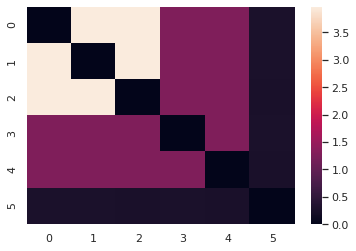

In [3]:
Gorig = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
for u,v,d in Gorig.edges(data=True):
    Gorig[u][v]['weight']= Gorig[u][v]['weight'] + np.random.normal(0,0.001)
#H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
#mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH1':1, 'ALKBH2':2, 'ALKBH3':4}
H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH3'])
mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH3':4}
G0 = nx.relabel_nodes(H, mapping)
A = nx.adjacency_matrix(G0).todense()
ax = sns.heatmap(A)

In [461]:
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

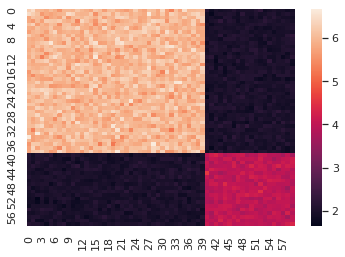

In [251]:
# Settings
n = 60 #number of nodes to generate
# Generate data
W = np.random.normal(2,0.1, (n,n))
label = np.repeat(np.asarray([0,0,0,0,1,1]),10)
row_id = np.asarray([i for i, e in enumerate(label) if e <= 0])
W[row_id[:,None],row_id] = W[row_id[:,None],row_id]+np.random.normal(4,0.2, (len(row_id),len(row_id)))
row_id = np.asarray([i for i, e in enumerate(label) if e >= 1])
W[row_id[:,None],row_id] = W[row_id[:,None],row_id]+np.random.normal(2,0.1, (len(row_id),len(row_id)))
ax = sns.heatmap(W)

In [5]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_log_prob(z, k, eta, B0, directed=False, selfloops=False):
  # the SBM log-likelihood generative steps
    n = z.shape[0]
    #k = int(n/2)
    #pi = ed.Dirichlet(name='pi', concentration=np.ones(k), sample_shape=[n])
    #eta = tfd.Normal(loc=0, scale=0.01).sample([k,k]) #beta prior for simple edges
    #z = tf.reshape(tfd.Sample(tfd.Categorical(probs=pi),1).sample(), [n,])
    #z = tfd.Bernoulli(probs=pi).sample()
    #z0 = tf.cast(z, tf.float32)
    p = tf.matmul(tf.matmul(z,eta),tf.transpose(z))
    p0 = tf.constant(B0,shape=[n,n])
    A = tfd.Normal(loc=p+p0, scale=0.1)
    #    unsupervised tree/DAG shrinking by factors of 2, supervised grouping by suggesting mergers in a similar ratio 
    #    use tfd.MixtureSameFamily to automatically integrate out the z draws. Construct the mixture dist from pair-wise counting of z draws
    #    p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
    #if weighted:
    #    A = ed.Poisson(name = 'A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
    #else:
    return A

In [511]:
GrefBlkVars

<tf.Tensor: id=167256, shape=(2, 2), dtype=float32, numpy=
array([[6.0014815, 2.148455 ],
       [2.148455 , 4.008241 ]], dtype=float32)>

In [582]:
import itertools as it

k = 2
ppi = [0.2,0.9]#tfd.Beta(concentration1=0.5, concentration0=0.5).sample([k])
z = tfd.RelaxedBernoulli(0.001, probs=ppi).sample(n)
totalW = sum(sum(W))
GrefBlkVars = np.random.normal(loc = totalW/len(W)/(len(W)-1)/2, scale = 0.1, size = (k,k)).astype("float32")
for i in range(k):
    for j in range(k):
        if (j==i): # only update diagonal entries for efficiency
            id1, id2 = zip(*it.product(np.where(label==i)[0],np.where(label==j)[0])) #cartesian product of the i j blocks
            totalW = sum(W[id1, id2]) #total edge weights of the block pair
            GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)

Y = tf.cast(tf.stack([W] * 50), dtype=tf.float32)
data_train = tf.data.Dataset.from_tensor_slices(Y).batch(1).shuffle(50)
#sns.heatmap(Y.numpy()[0])

In [532]:
#z = tf.Variable(tfd.RelaxedBernoulli(0.01, probs=[0.4,0.7]).sample(n), name="z")
tfd.Beta(concentration1=1, concentration0=1).sample(8)

<tf.Tensor: id=174163, shape=(8,), dtype=float32, numpy=
array([0.08613043, 0.79546803, 0.8956002 , 0.6075825 , 0.50500506,
       0.7033547 , 0.14158385, 0.95993435], dtype=float32)>

In [640]:
class VariationalEstep(tf.keras.Model):
#Optimizes pi and z with fixed phi, B, B0, (a, b are ommitted at the moment)

    def __init__(self, k, n, phi, name=None):
        super(VariationalEstep, self).__init__(name=name)
        self.pi = tf.Variable(tfd.Beta(concentration1=1, concentration0=1).sample([k]), name="pi")
        self.phi = tf.Variable(phi, name="phi")
        self.z = tf.Variable(tfd.RelaxedBernoulli(0.000001, probs=self.phi, validate_args=True, allow_nan_stats=False).sample(n), name="z")
        #self.b0 = tf.Variable(tf.exp(tf.random.normal([1])), name='b0')
        #self.s_alpha = tf.Variable(tf.exp(tf.random.normal([1])), name='s_alpha')
        #self.s_beta = tf.Variable(tf.exp(tf.random.normal([1])), name='s_beta')
    
    #@property
    #def ppi(self):
    #    """Variational posterior for the Beta distribution"""
    #    return tfd.Beta(concentration1=self.s_alpha, concentration0=self.s_beta)
    
    @property
    def pz(self):
        """Variational posterior for the bias parameter"""
        #ppi2 = tfd.Beta(concentration1=self.s_a, concentration0=self.s_b)
        return tfd.Bernoulli(probs=self.pi)
        
    def call(self, GrefBlkVars, B0, k, n):
        """Predict p(y|x)"""
        #sample = lambda x: x.sample() if sampling else x.mean()
        return SBM_log_prob(self.z, k, GrefBlkVars, B0)
    
    def KLlosses(self, phiNew):
        """Sum of KL divergences between posteriors and priors"""
        prior = tfd.Bernoulli(probs=phiNew)
        self.phi = self.phi.assign(phiNew)
        #phiNew = tf.reduce_sum(self.z, 0)/n
        return tf.reduce_sum(tfd.kl_divergence(self.pz, prior)) # L-2 norm for sparsity
    
    def losses(self, phiNew):
        """Sum of KL divergences between posteriors and priors"""
        prior = tfd.Bernoulli(probs=phiNew)
        self.phi = self.phi.assign(phiNew)
        #phiNew = tf.reduce_sum(self.z, 0)/n
        return tf.reduce_sum(tf.square(self.pi)) # L-2 norm for sparsity

In [514]:
z = model.pz.sample(n)
#n = z.shape[0]
#z = z[:,:,0]
phiNew = tf.dtypes.cast((tf.reduce_sum(z, 0)/n), dtype=tf.float32)
tf.reduce_sum(tf.abs(phiNew - model.phi))

<tf.Tensor: id=167308, shape=(), dtype=float32, numpy=0.19150472>

In [515]:
GrefBlkVars

<tf.Tensor: id=167256, shape=(2, 2), dtype=float32, numpy=
array([[6.0014815, 2.148455 ],
       [2.148455 , 4.008241 ]], dtype=float32)>

In [641]:
#import tensorflow.keras.backend as kerasB
k2 = 4
phi = np.asarray([0.333,0.666,0.2,0.2]).astype("float32")
#phi = np.repeat(np.asarray([0.1,0.4]),k2/k).astype("float32")
model = VariationalEstep(k2,n,phi)
L_RATE = 0.01
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

totalW = sum(sum(W))
GrefBlkVars = np.random.normal(loc = totalW/len(W)/(len(W)-1)/2, scale = 0.1, size = (k2,k2)).astype("float32")
for i in range(k):
    for j in range(k):
        if (j==i): # only update diagonal entries for efficiency
            id1, id2 = zip(*it.product(np.where(label==i)[0],np.where(label==j)[0])) #cartesian product of the i j blocks
            totalW = sum(W[id1, id2]) #total edge weights of the block pair
            GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)

@tf.function
def E_step(y):
    with tf.GradientTape() as tape:
        phi2 = tf.reduce_sum(model.z, 0)/n
        kl_loss = model.KLlosses(phi2)/n
        elbo_loss = kl_loss
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return model.trainable_variables

@tf.function
def M_step(y):
    with tf.GradientTape() as tape:
        log_prob = tf.reduce_mean(model(GrefBlkVars,2.0,k2,n).log_prob(y))
        phi2 = tf.reduce_sum(model.z, 0)/n
        model.losses(phi2)/n
        tf.print(phi2)
        elbo_loss = - log_prob
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return model.trainable_variables

In [642]:
# Fit the model
historyPi=[]
historyZ=[]
for (y_data) in data_train:
    E_step(y_data)
    posterior = M_step(y_data)
    historyPi.append(posterior[0].numpy())
    historyZ.append(posterior[1].numpy())

[0.206935465 0.806716621 0.223656952 0.326629251]
[0.195940718 0.795721829 0.212662205 0.315634817]
[0.184593573 0.784364641 0.201305225 0.30427739]
[0.173250601 0.772993743 0.189932093 0.292902023]
[0.162086889 0.761774719 0.178703874 0.281668276]
[0.151235759 0.750829339 0.167736948 0.27069062]
[0.140808329 0.740258 0.15712899 0.260065466]
[0.130890056 0.730141282 0.146961361 0.249873251]
[0.12154261 0.720540106 0.137297526 0.240177512]
[0.112809718 0.71149826 0.128183752 0.231024697]
[0.104720674 0.703044891 0.119650722 0.222445697]
[0.0972916633 0.69519639 0.111715496 0.214457795]
[0.0905262306 0.687957525 0.10438282 0.20706591]
[0.0844162926 0.681322575 0.0976467431 0.20026426]
[0.078943707 0.675276637 0.0914919749 0.194037765]
[0.0740821287 0.669797182 0.0858958513 0.188363984]
[0.0697992146 0.664856195 0.0808300376 0.183215]
[0.0660584196 0.660421252 0.0762622803 0.178558901]
[0.0628209487 0.65645808 0.0721580759 0.174361587]
[0.0600471683 0.652930677 0.0684818774 0.170587912]
[

In [643]:
model.trainable_variables

[<tf.Variable 'pi:0' shape=(4,) dtype=float32, numpy=array([0.05325781, 0.6371033 , 0.03218169, 0.4236765 ], dtype=float32)>,
 <tf.Variable 'z:0' shape=(60, 4) dtype=float32, numpy=
 array([[ 0.11552069,  0.9290632 , -0.05165579, -0.0420641 ],
        [ 0.11460605,  0.9342487 , -0.04699616, -0.03652738],
        [ 0.31870455,  0.31681848,  0.28671157,  0.29826862],
        [-0.17584835,  0.7385855 , -0.25311044,  0.7633977 ],
        [ 0.31598592,  0.313887  ,  0.28241786,  0.29347664],
        [ 0.7119605 ,  0.72345406, -0.27723444, -0.25893205],
        [ 0.8625249 ,  0.15174   ,  0.06042992,  0.06872934],
        [ 0.31528527,  0.3174681 ,  0.28499824,  0.29637134],
        [-0.07980467, -0.13740802,  0.8345983 ,  0.84745455],
        [ 0.24804103,  0.14081897,  0.00824774,  0.988732  ],
        [ 0.12244745,  0.9309203 , -0.04758054, -0.03814001],
        [ 0.7091303 ,  0.7212197 , -0.27925754, -0.2608431 ],
        [ 0.7094802 ,  0.7224707 , -0.27805683, -0.25967067],
        [ 0.

In [635]:
#model.z/tf.reduce_sum(model.z, 1).numpy()
tf.linalg.normalize(
    model.z, ord='euclidean', axis=1
)

(<tf.Tensor: id=210963, shape=(60, 4), dtype=float32, numpy=
 array([[-0.15264595,  0.6844756 ,  0.6920504 , -0.17105167],
        [ 0.06441861,  0.9959355 ,  0.03757107,  0.05051007],
        [ 0.3901173 ,  0.5510202 ,  0.5072079 ,  0.53565407],
        [-0.14642009,  0.67493033, -0.18461987,  0.6992465 ],
        [ 0.05084095,  0.9969317 ,  0.03537505,  0.0478648 ],
        [-0.14833981,  0.6846327 ,  0.6937305 , -0.16736609],
        [ 0.6658001 , -0.10016926,  0.7255028 , -0.1425558 ],
        [ 0.06045878,  0.9964128 ,  0.03513552,  0.04766182],
        [-0.05139338,  0.16121039,  0.13461278,  0.9763449 ],
        [ 0.37770623,  0.5547856 ,  0.5099145 ,  0.53808737],
        [ 0.64976674, -0.10352357,  0.73911667, -0.14419644],
        [-0.05272242,  0.16840649,  0.12677225,  0.9761088 ],
        [ 0.04849553,  0.9967817 ,  0.03857806,  0.05085436],
        [ 0.93717426,  0.2865234 ,  0.1307123 ,  0.15007636],
        [-0.05735123,  0.17653207,  0.9716503 ,  0.14643385],
        [

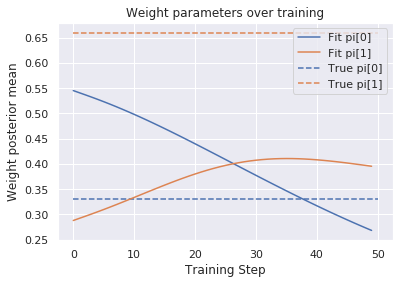

In [610]:
# Plot value of weights over training
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
records = np.stack(historyPi, axis=1)
pi = [0.33,0.66]
plt.figure()
for iW in range(k):
  plt.plot(records[iW], 
           label='Fit pi[{}]'.format(iW), 
           color=colors[iW])
  plt.hlines(pi[iW], 0, 50, 
             label='True pi[{}]'.format(iW), 
             color=colors[iW], linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Weight posterior mean')
plt.title('Weight parameters over training')
plt.legend()
plt.show()

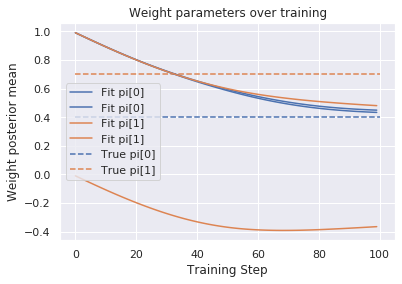

In [459]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
records = np.stack(historyZ, axis=1)
pi = [0.4,0.7]
plt.figure()
for iW in range(k):
  plt.plot(records[iW], 
           label='Fit pi[{}]'.format(iW), 
           color=colors[iW])
  plt.hlines(pi[iW], 0, 100, 
             label='True pi[{}]'.format(iW), 
             color=colors[iW], linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Weight posterior mean')
plt.title('Weight parameters over training')
plt.legend()
plt.show()

In [83]:
fig = plt.figure()
fig.set_size_inches(6.4, 8)
v = np.linspace(-2, 2, 400)

# Plot weight posteriors
probs = model.weight.prob(v*np.ones([D, 1]))
for i in range(D):
    plt.subplot(D+1, 1, i+1)
    plt.plot(v, probs[i, :])
    plt.axvline(x=w_true[i], linestyle='--', color='k')
    plt.title('W[{}]'.format(i))
    
# Plot Bias posterior
plt.subplot(D+1, 1, D+1)
plt.plot(v, model.bias.prob(v))
plt.axvline(x=b_true, linestyle='--', color='k')
plt.title('Bias')

plt.tight_layout()
plt.show()

AttributeError: 'VariationalEstep' object has no attribute 'weight'

<Figure size 460.8x576 with 0 Axes>

In [202]:
model.trainable_variables
#np.stack(history, axis=1)[0]

[<tf.Variable 'w_loc:0' shape=(4, 1) dtype=float32, numpy=
 array([[ 1.0092869],
        [ 0.0531522],
        [-0.4896717],
        [ 1.7498957]], dtype=float32)>,
 <tf.Variable 'w_std:0' shape=(4, 1) dtype=float32, numpy=
 array([[-0.49667665],
        [-0.8972007 ],
        [-1.8095822 ],
        [-1.850747  ]], dtype=float32)>,
 <tf.Variable 's_alpha:0' shape=(1,) dtype=float32, numpy=array([1.5395766], dtype=float32)>,
 <tf.Variable 's_beta:0' shape=(1,) dtype=float32, numpy=array([3.2281187], dtype=float32)>]

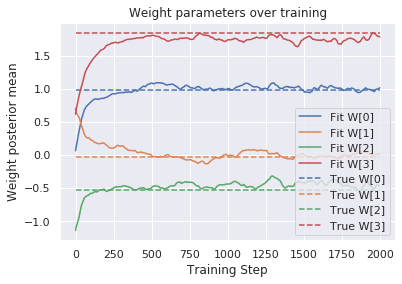

In [215]:
# Plot value of weights over training
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
records = np.stack(history, axis=1)
plt.figure()
for iW in range(D):
  plt.plot(records[iW], 
           label='Fit W[{}]'.format(iW), 
           color=colors[iW])
  plt.hlines(w_true[iW], 0, 2000, 
             label='True W[{}]'.format(iW), 
             color=colors[iW], linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Weight posterior mean')
plt.title('Weight parameters over training')
plt.legend()
plt.show()

In [90]:
# Plot value of bias over training
plt.figure()
plt.plot(model.bias.trace(v), label='fit')
plt.axhline(b_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior mean')
plt.title('Bias parameter over training')
plt.legend()
plt.show()

AttributeError: 'Normal' object has no attribute 'trace'

<Figure size 432x288 with 0 Axes>

In [103]:
log_joint = ed.make_log_joint_fn(SBM_log_prob)
# Function to compute the log posterior probability
n = len(H)
A_obs = tf.convert_to_tensor(nx.to_numpy_array(H), dtype=tf.float32)
print(A_obs)
#def setParameters(k, label):
k = int(n/2)
ppi = ed.Beta(name='test', concentration1=0.5, concentration0=0.5, sample_shape=[n,k]).numpy().astype("float32")
pz = ed.Bernoulli(probs=ppi, name="z")
print(pz)
peta = ed.Normal(loc=2, scale=1, name="eta", sample_shape=[k,k]) 
def target_log_prob_fn(eta, z):
  return log_joint(
      G = H,
      pi = ppi,
      k = k,
      z = z,
      eta = eta,
      A=A_obs)

# set initial state (drawn from prior built from OG subgraphs)
#
#
# Prior design will be key here, needs external input
#eta = tf.random.uniform([k,k], minval=0, maxval=1, dtype=tf.float32)
x = target_log_prob_fn(peta,pz) #test the target_log_prob_fn with initial state
print(x)
#with tf.GradientTape() as tape:
#    preds = x
#grads = tape.gradient(preds,eta,z)
#print(grads)
#np.exp(-300)

tf.Tensor(
[[0.         0.27959284 0.28171605 0.277801   0.2803751  0.2784048 ]
 [0.27959284 0.         1.2782962  1.2784787  1.2783674  1.2809516 ]
 [0.28171605 1.2782962  0.         3.966004   1.2794775  3.964147  ]
 [0.277801   1.2784787  3.966004   0.         1.2813898  3.9635909 ]
 [0.2803751  1.2783674  1.2794775  1.2813898  0.         1.2805036 ]
 [0.2784048  1.2809516  3.964147   3.9635909  1.2805036  0.        ]], shape=(6, 6), dtype=float32)
RandomVariable("
[[0 1 1]
 [0 0 0]
 [1 0 0]
 [1 1 0]
 [1 0 1]
 [1 0 1]]", shape=(6, 3), dtype=int32, device=/job:localhost/replica:0/task:0/device:GPU:0)
tf.Tensor(-101713.94, shape=(), dtype=float32)


In [97]:
Nsamples = 50  # final number of samples
Nburn = 1000    # number of tuning samples

unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity()
]

# set up Hamiltonian MC
def sampleMedian(peta,pz,target_log_prob_fn):
    hmc_kernel =tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=target_log_prob_fn)
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=Nsamples,
        num_burnin_steps=Nburn,
        current_state=[peta, pz],
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        parallel_iterations=100,
        kernel=hmc_kernel)
    return np.median(kernel_results.accepted_results.target_log_prob), tf.reduce_mean(states[0], axis=[0]).numpy(), states[1].numpy() ##median for posterior estimates
 ##median for posterior estimates
#kernel_results.is_accepted.numpy().mean()

In [45]:
pi0 = ed.Beta(name='test', concentration1=0.5, concentration0=0.5, sample_shape=[len(Gnew),k])
labelOneHot = tf.one_hot(label.astype(int), k, dtype = "float32")
labelOneHot

<tf.Tensor: id=4580236, shape=(6, 6), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)>

In [102]:
import cProfile 
import itertools as it

#def f():
Gnew = relabel.convert_node_labels_to_integers(H, label_attribute = "term") #initilaization
k = len(Gnew)
label = np.zeros(k)
label[1]=3
label[2]=2
label[3]=1
label[4]=3
label[5]=3
print(label)
#label[k-1]=4
knew = int(max(label)+1)

totalW = sum(sum(nx.to_numpy_array(Gnew)))
GrefBlkVars = np.random.normal(loc = totalW/len(Gnew)/(len(Gnew)-1)*2, scale = 1, size = (k,k)).astype("float32")
for i in range(knew):
    for j in range(knew): 
        if (j==i): # only update diagonal entries for efficiency
            id1, id2 = zip(*it.product(np.where(label==i)[0],np.where(label==j)[0])) #cartesian product of the i j blocks
            totalW = sum(nx.to_numpy_array(Gnew)[id1, id2]) #total edge weights of the block pair
            GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)

pi0 = ed.Beta(name='test', concentration1=0.5, concentration0=0.5, sample_shape=[len(Gnew),k])
labelOneHot = tf.one_hot(label.astype(int), k, dtype = "float32")
ppi = ((labelOneHot*9 + pi0)/10)
print(ppi)
pz = ed.Bernoulli(probs=ppi, name="z")
print(pz)
print("start")
hmc_kernel =tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=target_log_prob_fn)
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=Nsamples,
    num_burnin_steps=Nburn,
    current_state=[GrefBlkVars, pz],
    trace_fn=(lambda current_state, kernel_results: kernel_results),
    parallel_iterations=100,
    kernel=hmc_kernel)
#print(kernel_results.inner_results)
median, etap, zp = np.median(kernel_results.accepted_results.target_log_prob), tf.reduce_mean(states[0], axis=[0]).numpy(), states[1].numpy() ##median for posterior estimates
#cProfile.run('f()')    
#for zps in zp:
#    print(zps)  
zp

[0. 3. 2. 1. 3. 3.]
tf.Tensor(
[[9.9150121e-01 8.3591036e-02 1.4165543e-04 2.2354249e-02 9.6164323e-02
  9.2227735e-02]
 [5.9432067e-02 5.6999512e-02 7.8185096e-02 9.8215514e-01 9.8205969e-02
  7.5937428e-02]
 [7.2060928e-02 7.1150758e-03 9.0704405e-01 4.8894517e-02 9.3653463e-02
  5.3196389e-02]
 [9.7661622e-02 9.9992055e-01 2.4174378e-05 2.8825530e-03 2.1075023e-02
  8.3331384e-02]
 [7.8769922e-02 1.5600803e-02 1.4200385e-02 9.6123827e-01 2.7073845e-02
  1.5725760e-03]
 [7.2168812e-02 7.5138204e-02 1.2479568e-03 9.5867825e-01 9.7988375e-02
  8.4341615e-02]], shape=(6, 6), dtype=float32)
RandomVariable("
[[1 0 0 0 0 0]
 [1 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 1 0]]", shape=(6, 6), dtype=int32, device=/job:localhost/replica:0/task:0/device:GPU:0)
start


TypeError: Cannot convert 1.0 to EagerTensor of dtype int32

In [17]:
# Merge quasi-cliques with more than 3 overlapping nodes
def merge_cliques(Clist):
    for i in range(0, len(Clist)):
        c1 = Clist[i]
        for j in range(i+1, len(Clist)):
            c2 = Clist[j]
            if (len(c1.intersection(c2))>1): # define quasi-cliques with number of overlapping nodes
                c3 = c1.union(c2)
                Clist.insert(0,c3)
                Clist.remove(c1)
                Clist.remove(c2)
                return merge_cliques(Clist)
    return Clist

In [18]:
import networkx.algorithms.clique as clique
import itertools as it
import random 

def getCandidatesB(G, Gref, labels):
    parentList = []
    for source, target in Gref.edges():
        if len(Gref.in_edges(source, data=True)) == 0: #leaf nodes (genes)
            tup = (target,Gref.nodes[target]['level'])
            parentList.append(tup)
    #random.shuffle(parentList)
    tmp = sorted(parentList, key=lambda t: t[1]) #sort leaves by level
    parentSet = list(set(parentList))

    merges = []
    for parent in parentSet[:5]:
        c = []
        for predecessor in Gref.predecessors(parent[0]): #only include leaves
            if len(Gref.in_edges(predecessor, data=True)) == 0:
                c.append(predecessor)
        merges.append(set(c))
    print(merges)
    
    CliXO = {}    
    nodeSet = sorted(set().union(*merges))
    for x in nodeSet:
        CliXO[x] = []
        for idx, y in enumerate(merges): 
            if (x in y) and len(CliXO[x])<3: #only top 2 appearance are considered in Bayesian assignments
                CliXO[x].append(idx)
    combinations = it.product(*(CliXO[Name] for Name in nodeSet))    
    Llist = []
    for update in combinations:
        labelsNew = labels.copy()
        for idx, x in enumerate(update):        
            nodeIDs = [x for x,y in G.nodes(data=True) if y['term']==nodeSet[idx]]
            if nodeIDs!=[]:
                labelsNew[nodeIDs[0]] = len(labels)+x #assign brand new block labels
        b,c =np.unique(labelsNew, return_inverse=True)
        Llist.append(c)
    return Llist

In [19]:
import networkx.algorithms.clique as clique
import itertools as it

def getCandidates(G, labels):
    edgesTop=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)
    #percent = int(len(edgesTop)/5000) # adjust for layer size
    eList = [(x[0],x[1]) for x in edgesTop[:10]]
    sub = G.edge_subgraph(eList)
    graphs = [sub.subgraph(c) for c in nx.connected_components(sub)]
    #print(len(graphs))
    max_clique_sets = [clique.find_cliques(s) for s in graphs]
    cliques = []
    for clist in max_clique_sets:
        tmp = []
        for c in clist:
            if (len(c)>=2): #(len(c)<=3) control size of cliques
                cohesion = 0
                for idx, x in enumerate(c):
                    for idy, y in enumerate(c):
                        if (idy>idx):
                            cohesion = cohesion + G[x][y]['weight']
                tup = (set(c),cohesion/(len(c)-1)) #higher order cliques prioritized
                tmp.append(tup)
        tmp = sorted(tmp, key=lambda t: t[1], reverse=True) #sort cliques
        cliques += tmp[:3] #keep only top 3 cliques for each component
    
    CliList = sorted(cliques, key=lambda t: t[1], reverse=True)
    #print(CliList)
    cliquesFiltered0 = [x[0] for x in CliList]
    cliquesFiltered = merge_cliques(cliquesFiltered0)

    CliXO = {}    
    nodeSet = sorted(set().union(*cliquesFiltered))
    for x in nodeSet:
        CliXO[x] = []
        for idx, y in enumerate(cliquesFiltered): 
            if (x in y) and len(CliXO[x])<3: #only top 2 appearance are considered in Bayesian assignments
                CliXO[x].append(idx)
    combinations = it.product(*(CliXO[Name] for Name in nodeSet))
    Llist = []
    for update in combinations:
        labelsNew = labels.copy()    
        for idx, x in enumerate(update):
            labelsNew[nodeSet[idx]] = len(labels)+x #assign brand new block labels
        b,c =np.unique(labelsNew, return_inverse=True) #Re-arranged block labels
        Llist.append(c)
    return Llist

In [46]:
ppi = ed.Beta(name='test', concentration1=0.5, concentration0=0.5, sample_shape=[len(Gnew),k])
#labelOneHot = tf.one_hot(label.astype(int), k, dtype = "float64")
#ppi = ((labelOneHot*9 + pi0)/10).numpy()
print(ppi)
pz = ed.Bernoulli(probs=ppi, name="z").numpy().astype("float32")

RandomVariable("
[[2.1630913e-02 2.1911925e-01 6.0801375e-01 2.3340913e-02 4.2660567e-01
  1.2471968e-03]
 [6.7796868e-01 6.1399322e-03 9.2684454e-01 4.9677929e-03 2.5831871e-03
  2.2587794e-01]
 [9.8373145e-01 1.9694209e-01 8.5290569e-01 9.9664755e-02 3.7296563e-02
  1.2566622e-01]
 [5.5358332e-01 7.4920867e-04 4.5156863e-01 8.6388826e-02 4.1466579e-01
  3.7940715e-02]
 [1.6994862e-01 6.9358659e-01 8.7011725e-01 8.4133768e-01 8.7127382e-01
  2.1691557e-02]
 [2.2245787e-01 9.0725172e-01 9.1605047e-03 4.3644923e-01 8.7335831e-01
  9.5479351e-01]]", shape=(6, 6), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)


In [82]:
Gnew = relabel.convert_node_labels_to_integers(H, label_attribute = "term") #initilaization
k = len(Gnew)
label = np.arange(k)
#label[k-1]=4
#Llist = getCandidates(Gnew, label)
#label = Llist[0]
print(label)
label[1]=3
label[2]=2
label[3]=1
label[4]=3
label[5]=3
print(label)

knew = int(max(label)+1)
totalW = sum(sum(nx.to_numpy_array(Gnew)))
GrefBlkVars = np.random.normal(loc = totalW/len(Gnew)/(len(Gnew)-1)*2, scale = 1, size = (k,k)).astype("float32")
for i in range(knew):
    for j in range(knew): 
        if (j==i): # only update diagonal entries for efficiency
            id1, id2 = zip(*it.product(np.where(label==i)[0],np.where(label==j)[0])) #cartesian product of the i j blocks
            totalW = sum(nx.to_numpy_array(Gnew)[id1, id2]) #total edge weights of the block pair
            GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)

pi0 = ed.Beta(name='test', concentration1=0.5, concentration0=0.5, sample_shape=[len(Gnew),k])
labelOneHot = tf.one_hot(label.astype(int), k, dtype = "float32")
ppi = ((labelOneHot*9 + pi0)/10).numpy()
print(ppi)
pz = ed.Bernoulli(probs=ppi, name="z").numpy().astype("float32")
print(pz)
print("start")

def target_log_prob_fn(eta, z):
          return log_joint(
              G = Gnew,
              pi = ppi,
              k = k,
              z = z,
              eta = eta,
              A=A_obs)
sampleMedian(GrefBlkVars, pz, target_log_prob_fn)

[0 1 2 3 4 5]
[0 3 2 1 3 3]
[[9.0968627e-01 6.0425815e-03 3.1027853e-02 9.9435143e-02 9.8250471e-02
  9.1683626e-02]
 [9.6870132e-02 4.7474176e-02 7.9094425e-02 9.2610180e-01 8.9309009e-04
  2.9385027e-02]
 [9.9619895e-02 5.1300466e-02 9.3635929e-01 6.7190975e-02 3.1441867e-02
  6.3950732e-02]
 [1.8205615e-02 9.0766907e-01 6.5513253e-02 9.2963353e-02 9.5003717e-02
  9.2944130e-02]
 [7.4319616e-02 2.7254974e-02 9.7775295e-02 9.9077451e-01 2.7600228e-04
  4.2684421e-02]
 [7.0076704e-02 6.7543462e-02 2.8869843e-02 9.3809015e-01 6.8201147e-02
  2.5242468e-02]]
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
start


(-252549.73,
 array([[2.2355268 , 3.82      , 4.0992336 , 4.2627587 , 2.7543783 ,
         4.3185267 ],
        [2.862821  , 2.4051774 , 0.38524345, 3.1432257 , 2.877693  ,
         1.4863888 ],
        [3.8055875 , 4.003351  , 2.0023487 , 5.0776887 , 4.083504  ,
         2.1247787 ],
        [2.9665651 , 3.8310997 , 2.2960706 , 3.244458  , 3.3503442 ,
         4.9849043 ],
        [2.2937925 , 3.4144106 , 4.112496  , 2.2975376 , 2.6383524 ,
         3.5366905 ],
        [1.1845812 , 2.5638838 , 4.63249   , 4.817605  , 1.2932765 ,
         4.3738093 ]], dtype=float32),
 array([[[ 4.965028  ,  0.57940984, -0.01966542,  1.0065222 ,
          -0.4598049 ,  1.351397  ],
         [-0.6121663 , -0.00545061,  0.5720167 ,  2.8082206 ,
          -2.3816035 ,  0.25077295],
         [-1.0660682 ,  0.3569205 ,  3.712689  , -0.64813346,
           1.8766303 , -0.8761083 ],
         [ 1.6078721 ,  0.12102258, -0.3351267 ,  0.49102288,
          -1.3176823 ,  0.26064655],
         [ 1.3841751 ,  2.54

In [31]:
def buildLayer(Gnew, Gref, Llist):
    Mlist = []
    A_obs = tf.convert_to_tensor(nx.to_numpy_array(Gnew), dtype=tf.float32)
    k = len(Gnew)
    label = Llist[0]
    knew = max(label+1)
    #labelOneHotMixed = np.zeros((len(Gnew), knew))
    #for iteration in range (0,len(Llist)):
        #labelOneHotMixed += tf.one_hot(label.astype(int), knew, dtype = "float64")
    labelOneHotMixed = tf.one_hot(label.astype(int), k, dtype = "float64")#labelOneHotMixed/len(Llist)
    #print(label)
    #print(labelOneHotMixed)
    pi0 = ed.Beta(name='test', concentration1=0.5, concentration0=0.5, sample_shape=[len(Gnew),k])
    labelOneHot = tf.one_hot(label.astype(int), k, dtype = "float32")
    ppi = ((labelOneHot*9 + pi0)/10).numpy()
    print(ppi)
    pz = ed.Bernoulli(probs=ppi, name="z").numpy().astype("float32")
    #print(pz)
    def target_log_prob_fn(eta, z):
          return log_joint(
              G = Gnew,
              pi = ppi,
              k = k,
              z = z,
              eta = eta,
              A=A_obs)
    # set initial state (drawn from prior built from OG subgraphs)
    # Prior strength tuning parameter
    # Prior design will be key here, needs external input from corresponding OG layer
    
    totalW = sum(sum(nx.to_numpy_array(Gref)))
    GrefBlkVars = np.random.normal(loc = totalW/len(Gref)/(len(Gref)-1)*2, scale = 1, size = (k,k))
    print(GrefBlkVars)
    for i in range(knew):
        for j in range(knew): 
            if (j==i): # only update diagonal entries for efficiency
                id1, id2 = zip(*it.product(np.where(label==i)[0],np.where(label==j)[0])) #cartesian product of the i j blocks
                totalW = sum(nx.to_numpy_array(Gref)[id1, id2]) #total edge weights of the block pair
                GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
    GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)
    #peta = ed.Normal(loc=GrefBlkVars, scale=1, name="eta")
    #peta = tf.random.uniform([knew,knew], minval=0, maxval=1, dtype=tf.float32)
    #tf.reshape(tf.concat([petaA, petaB], axis=1),[2,1])
    median, etap, zs = sampleMedian(GrefBlkVars, pz, target_log_prob_fn)
    tup = (iteration, median, etap, zs) #tuple for index and posterior
    #Mlist = np.exp(Mlist - max(Mlist))
    #norm = [float(i)/sum(Mlist) for i in Mlist] 
    return tup #higher order cliques prioritized

In [32]:
def updateDAG(G, NodeMerge, terms):
    size = len(NodeMerge);
    nodeSet = sorted(set().union(*NodeMerge))
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        newNodeV = np.sum(A[nodes,:],axis=0)/len(nodes)
        B = np.vstack([A, newNodeV])
        newNodeC = np.sum(B[:,nodes],axis=1)/len(nodes)
        A = np.column_stack([B, newNodeC])
        
    #print(nodeSet)
    A = np.delete(A, nodeSet, axis = 0)
    #print(A.shape)
    A = np.delete(A, nodeSet, axis = 1)
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    np.fill_diagonal(A, 0)
    Gnew = nx.from_numpy_matrix(A)
    Gnew = relabel.convert_node_labels_to_integers(Gnew,label_attribute = "term") 
    
    for node in nodeSet:
        if node in terms:
            del terms[node]
    return Gnew, {i:v for i,(k,v) in enumerate(terms.items(),0)}

In [33]:
def updateDAGB(G, Gref, NodeMerge, terms):
    nodeSet = sorted(set().union(*NodeMerge))
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        G.add_node(terms[len(G)-len(NodeMerge)])
        target = terms[len(G)-len(NodeMerge)]
        for source in nodes:
            if G.has_node(source):
                G = nx.contracted_nodes(G, target, source, self_loops=False) 
            #if len(Gref.in_edges(Gref[terms[target]], data=True)) == 0: #update OG ref DAG
            if Gref.has_node(terms[source]):
                targetRef = Gref.successors(terms[source])
                for targetRef0 in targetRef:
                    Gref = nx.contracted_nodes(Gref, targetRef0, terms[source], self_loops=False) 
                    Gref.nodes[targetRef0]['level'] = 10
                    break
    #for node in Gref.nodes():
    #    if len(Gref.in_edges(node, data=True)) == 0: #terminal nodes
    #        Gref.nodes[node]['level'] = 0
    #    else: Gref.nodes[node]['level'] = -1   
    #level = 0
    #newLevel = 0
    #while  newLevel == level:
    #    newLevel = get_level(level)
    #    level += 1
    
    G = relabel.convert_node_labels_to_integers(G)
    for node in nodeSet:
        if node in terms:
            del terms[node]
    return G, Gref, {i:v for i,(k,v) in enumerate(terms.items(),0)}

In [34]:
from collections import Counter
from networkx import relabel

#def f():
#H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
#Gnew = relabel.convert_node_labels_to_integers(H, label_attribute = "term") #initilaization
Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
hierarchy = [] # for ddot ontology output
model = [] # for generative modeling
subsystem = 0 # for ddot ontology output
loop=0
#
print("entering un-supervised stage")        
#consistency between ref and bayesian posterior required after Supervised levels    
while True:
    k = len(Gnew)
    label = np.arange(k)
    print(k)
    knew = 1
    Llist = getCandidates(Gnew, label)
    #print(Llist)
    #print(max(Llist[0]))
    if (len(Llist) <=1) & (max(Llist[0])<= 1): #catch final top block before merging
        print("root block")
        break 
    ModelPosterior = buildLayer(Gnew, Gnew, Llist)
    print(ModelPosterior)
    #newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold
    
    NodeMerge = [] #nodes to be merged, nested lists of motifs
    for node in Gnew.nodes():
        model.append(str(loop)+"th loop:"+terms[node])
        
    newLabel = Llist[0]
    dup = [item for item, count in Counter(newLabel).items() if count > 1] #list only duplicate labels where merges happen
    for dupL in dup: 
        nodes = [idx for idx,label in enumerate(newLabel) if label==dupL]
        #if(all(not set(nodes).issubset(set(x)) for x in NodeMerge)):
        if nodes not in NodeMerge:
            NodeMerge.append(nodes)
            for node in nodes: #update ddot ontology with new merges
                model.append((terms[node],"subsystem"+str(subsystem),"ddot", Llist[0][1],Llist[0][2],newLabel)) #update ddot ontology
            terms[len(terms)] = "subsystem"+str(subsystem)
            subsystem += 1
    model.append((str(i)+"th posterior",newLabel))
    print(NodeMerge)
    Gnew, terms = updateDAG(Gnew, NodeMerge, terms) #update the graph with node mergers/splits
    loop += 1

entering un-supervised stage
437
[[0.9519011  0.08983864 0.04903197 ... 0.0890054  0.02639111 0.03530934]
 [0.00310551 0.9993817  0.09740581 ... 0.02620306 0.06299319 0.08351763]
 [0.02572707 0.05884276 0.94409114 ... 0.09591391 0.00164711 0.0956714 ]
 ...
 [0.09748723 0.05821756 0.05543987 ... 0.0972811  0.09754336 0.0415147 ]
 [0.03789595 0.03036326 0.02038427 ... 0.0166349  0.09683013 0.09247004]
 [0.0962229  0.09997234 0.0545922  ... 0.01757307 0.09779156 0.01351937]]
[[ 2.6444351   2.26729119 -0.74455162 ...  1.14678281  0.76832255
   1.46202163]
 [ 1.29870979  1.9960178   0.7888708  ...  1.26813408  2.05604081
   2.16801368]
 [ 2.19773597  1.20626664  1.1977897  ...  1.73765521  1.325387
   2.45985929]
 ...
 [ 2.154272    1.04127755  1.96552257 ...  2.69703206  3.07743639
   2.07049455]
 [ 2.5596004   1.62376905  1.88106637 ...  1.40403195  3.59454233
   0.72352799]
 [-0.47092018  1.85914797  1.59510918 ...  1.81509984  2.22405232
   3.64482109]]
(0, nan, array([[0.        , 0.00

KeyboardInterrupt: 

In [19]:
from collections import Counter
from networkx import relabel

#def f():
Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
model2 = [] # for ddot ontology output
subsystem = 0 # for ddot ontology output
loop = 0
#
Gref = nx.from_pandas_edgelist(df,1,0,[2],nx.DiGraph)
for node in Gref.nodes():
    if len(Gref.in_edges(node, data=True)) == 0: #terminal nodes
        Gref.nodes[node]['level'] = 0
    else: Gref.nodes[node]['level'] = -1
level = 0
newLevel = 0
while  newLevel == level:
    newLevel = get_level(level)
    level += 1

#Supervised merging steps, controlled by number_of_edges    
while True:    
    k = len(Gnew)
    label = np.arange(k)
    print(k)
    Llist = getCandidatesB(Gnew, Gref, label)
    ModelPosterior = buildLayer(Gnew, Gnew, Llist)
    print(ModelPosterior)
    newInternal = [x for x in ModelPosterior[:5]] # keep top 10 Bayesian assignemtns
    NodeMerge = [] #nodes to be merged, nested lists of motifs
    for node in Gnew.nodes():
        model2.append(str(loop)+"th loop:"+terms[node])
    for i in range (0,len(newInternal)): #recreate the filtered merges
        newLabel = Llist[newInternal[i][0]]
        #print(newLabel)        
        dup = [item for item, count in Counter(newLabel).items() if count > 1] #list only duplicate labels where merges happen
        for dupL in dup: 
            nodes = [idx for idx,label in enumerate(newLabel) if label==dupL]
            #if(all(not set(nodes).issubset(set(x)) for x in NodeMerge)):
            if nodes not in NodeMerge:
                NodeMerge.append(nodes)
                for node in nodes: #update ddot ontology with new merges
                    model2.append((terms[node],"subsystem"+str(subsystem),"ddot",newInternal[i][1],newInternal[i][2],newLabel)) #update ddot ontology
                terms[len(terms)] = "subsystem"+str(subsystem)
                subsystem += 1
        model2.append((str(i)+"th posterior",newLabel))
    print(NodeMerge)
    Gnew, Gref, terms = updateDAGB(Gnew, Gref, NodeMerge, terms) #update the graph with node mergers/splits
    loop += 1
    if Gnew.number_of_edges() <= 55266:
        break  
        
print("entering un-supervised stage")        
#consistency between ref and bayesian posterior required after Supervised levels    
while True:
    k = len(Gnew)
    label = np.arange(k)
    print(k)
    Llist = getCandidates(Gnew, label)
    ModelPosterior = buildLayer(Gnew, Gnew, Llist)
    print(ModelPosterior)
    newInternal = [x for x in ModelPosterior[:10]] # keep top 10 Bayesian assignemtns
    #newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold
    NodeMerge = [] #nodes to be merged, nested lists of motifs
    for node in Gnew.nodes():
        model2.append(str(loop)+"th loop:"+terms[node])
    for i in range (0,len(newInternal)): #recreate the filtered merges
        newLabel = Llist[newInternal[i][0]]
        #print(newLabel)        Gnew
        dup = [item for item, count in Counter(newLabel).items() if count > 1] #list only duplicate labels where merges happen
        for dupL in dup: 
            nodes = [idx for idx,label in enumerate(newLabel) if label==dupL]
            #if(all(not set(nodes).issubset(set(x)) for x in NodeMerge)):
            if nodes not in NodeMerge:
                NodeMerge.append(nodes)
                for node in nodes: #update ddot ontology with new merges
                    model2.append((terms[node],"subsystem"+str(subsystem),"ddot",newInternal[i][1],newInternal[i][2],newLabel)) #update ddot ontology
                terms[len(terms)] = "subsystem"+str(subsystem)
                subsystem += 1
        model2.append((str(i)+"th posterior",newLabel))
    print(NodeMerge)
    Gnew, terms = updateDAG(Gnew, NodeMerge, terms) #update the graph with node mergers/splits
    loop += 1
    if Gnew.number_of_edges() <=0:
        break    

437
[{'RNF168'}, {'DDB2', 'RBX1', 'CETN2', 'DDB1', 'RAD23B', 'CUL4A', 'XPC'}, {'GPS1', 'COPS4', 'COPS5', 'COPS7B', 'COPS6', 'COPS8', 'COPS2', 'COPS3', 'COPS7A'}, {'HUS1', 'POLD4', 'PCNA', 'FEN1', 'POLD3', 'POLD2', 'POLD1', 'LIG1', 'WRN'}, {'PIF1', 'TOP2B', 'TOP2A', 'TOP1'}]



KeyboardInterrupt: 

In [ ]:
#{i:v for i,(k,v) in enumerate(terms.items(),0)}
terms

In [ ]:
del terms[0]
{i:v for i,(k,v) in enumerate(terms.items(),0)}

In [ ]:
model.reverse()
model

In [ ]:
#model.reverse()
model0 = model

In [ ]:
import pickle

with open('resultNew/hierarchy-base.save', 'wb') as fp:
    pickle.dump(model, fp)

In [ ]:
Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
Gref = nx.from_pandas_edgelist(df,1,0,[2],nx.DiGraph)
genes = [u for u,v,e in Gref.edges(data=True) if e[2] == 'Gene-Term']
len(Gnew.nodes())-len(set(genes))
for u in Gref.nodes(data=True):
    [x for x,y in Gnew.nodes(data=True) if y['term']==5]

In [ ]:
Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
Gnew.nodes(data=True)

In [ ]:
k = len(Gnew)
print(k)
labels = np.arange(k)
parentList = []
for source, target in Gref.edges(): #calculate logLikeRatio along edges
    if len(Gref.in_edges(source, data=True)) == 0: #leaf nodes (genes)
        parentList.append(target)
random.shuffle(parentList)
parentSet = set(parentList[:5])      
print(parentSet)

merges = []
for parent in parentSet:
    c = []
    for predecessor in Gref.predecessors(parent): #updat
        #print(predecessor)
        if len(Gref.in_edges(predecessor, data=True)) == 0:
            c.append(predecessor)
    merges.append(set(c))
print(merges)
        
CliXO = {}    
nodeSet = sorted(set().union(*merges))
for x in nodeSet:
    CliXO[x] = []
    for idx, y in enumerate(merges): 
        if (x in y) and len(CliXO[x])<3: #only top 2 appearance are considered in Bayesian assignments
            CliXO[x].append(idx)
combinations = it.product(*(CliXO[Name] for Name in nodeSet))    
Llist = []
for update in combinations:
    #print(update)
    labelsNew = labels.copy()    
    for idx, x in enumerate(update):        
        nodeIDs = [x for x,y in Gnew.nodes(data=True) if y['term']==nodeSet[idx]]
        labelsNew[nodeIDs[0]] = len(labels)+x
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)

In [ ]:
with open('resultNew/hierarchyQnew2Merge.save', 'wb') as fp:
    pickle.dump(list(G_new.edges), fp)

In [ ]:
sorted([n for n in G.in_degree()], reverse=True)  # degree sequence
inDegrees = G.in_degree()
for node, iDegree in inDegrees():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if iDegree == 3:
        print(node)

In [ ]:
for n, nbrs in G.adj.items():
    print(G.nodes.data()[n])
    print(G.in_edges(n, data=True))

In [ ]:
edgesTop